In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

%matplotlib inline

le = LabelEncoder()
cur_date = pd.Timestamp.now()

# Predspracovanie údajov pre strojové učenie - dataset 027 Sližik, Ürge (50 : 50)
## Extrakcia dát
Pre túto fázu sme sa rozhodli pracovať čisto s datasetom sessions
 * products nedokážeme nijako  mergenúť 
 * users obsahujú duplikátne id, a teda na to, aby sme spojili products s users by sme duplikátne id museli dropnúť, avšak po inner mergenutí by sme prišli o viacej ako 50% sessions, čo by nemuselo byť veľmi dobré pre náš model, keďže dáta v sessions najviac ovplyvňujú ack, ako sme zistili v prvej fáze

Po načítaní odstránime duplikátne riadky spolu s nepotrebnými id columns `product_ean`, `session_id`, `user_id`.

In [85]:
sessions = pd.read_csv("027/session.csv", encoding="utf_8", sep='\t')
sessions = sessions.drop_duplicates()
sessions = sessions.drop(columns=['product_ean', 'session_id', 'user_id'])

## Integrácia a čistenie dát
Naším cieľom je premeniť všetky dáta numerické hodnoty, očistiť ich od missing values za pomoci rôznych prístupov a odstrániť vychýlené hodnoty. 

In [86]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10928 entries, 0 to 11058
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move_duration        10917 non-null  float64
 1   pct_click_product_info          10917 non-null  float64
 2   pct_click                       10917 non-null  float64
 3   pct_rage_click                  10917 non-null  float64
 4   pct_mouse_move                  10917 non-null  float64
 5   wild_mouse_duration             10917 non-null  float64
 6   pct_wild_mouse                  10917 non-null  float64
 7   scroll_move_total_rel_distance  10917 non-null  float64
 8   pct_scrandom                    10917 non-null  float64
 9   total_load_time                 10928 non-null  float64
 10  screen_height                   10928 non-null  object 
 11  page_activity_duration          10917 non-null  float64
 12  pct_scroll_move                 10917

### Browser name Label Encoding
Na vyriešenie nahradenia enumových hodnôt pre `browser_name` sme sa rozhodli využiť metódu Label Encoding, kedy sa každej hodnote, ktorú môže enum nadobúdať priradí hodnota numerická.

In [87]:
def label_encoding(dataframe, column_name):
    dataframe[column_name] = le.fit_transform(dataframe[column_name])

    for encoded_value in set(dataframe[column_name]):
        original_value = le.inverse_transform([encoded_value])[0]
        print(f"Encoded Value: {encoded_value}, Original Value: {original_value}")

label_encoding(sessions, 'browser_name')

Encoded Value: 0, Original Value: chrome
Encoded Value: 1, Original Value: edge
Encoded Value: 2, Original Value: firefox
Encoded Value: 3, Original Value: mobile
Encoded Value: 4, Original Value: opera
Encoded Value: 5, Original Value: other
Encoded Value: 6, Original Value: safari


### Nenumerické hodnoty screen width, screen height 
Z EDA v predošlej fáze vieme, že `screen_width` a `screen_height` môžu nadobúdať okrem numerických hodnôt aj hodnoty `higher` a `lower` je preto potrebné ich nahradiť numerickými hodnotami - na to, aby sa zachovala koherentnosť možných hodnôt, ktoré stĺpce môžu nadobúdať sme sa rozhodli `higher` nahradiť max hodnotou a `lower` nahradiť min hodnotou stĺpca. 

In [88]:
def process_session_screen_sizes(dataframe):
    screen_width_data = list(sessions["screen_width"].unique())
    screen_width_numeric_values = [int(value) for value in screen_width_data if value.isdigit()]
    min_width = str(min(screen_width_numeric_values, default=None))
    max_width = str(max(screen_width_numeric_values, default=None))
    
    screen_height_data = list(sessions["screen_height"].unique())
    screen_height_numeric_values = [int(value) for value in screen_height_data if value.isdigit()]
    min_height = str(min(screen_height_numeric_values, default=None))
    max_height= str(max(screen_height_numeric_values, default=None))
    
    dataframe["screen_width"]=dataframe["screen_width"].str.replace("lower", min_width)
    dataframe["screen_width"]=dataframe["screen_width"].str.replace("higher", max_width)
    dataframe["screen_height"]=dataframe["screen_height"].str.replace("lower", min_height)    
    dataframe["screen_height"]=dataframe["screen_height"].str.replace("higher", max_height)
    
    dataframe["screen_height"] = pd.to_numeric(sessions["screen_height"], errors='coerce')
    dataframe["screen_width"] = pd.to_numeric(sessions["screen_width"], errors='coerce')
    return dataframe

sessions = process_session_screen_sizes(sessions)

### Rozbitie dátumu Session start na hour of day a month
Náš dataset obsahuje aj jeden dátum `session_start`, ktorý by sme mohli dropnúť, avšak pokiaľ by sme tak urobili prišli by sme o potenciálne vzácne údaje o tom v ktorých hodinách a ktorých mesiacoch užívatelia interagovali s naším eshopom, čo by mohlo potenciálne ovplyvniť ich rozhodnutie preto sme sa tieto údaje rozhodli zachovať - zo `session_start` sa stávajú dva nové stĺpce `month` a `hour_of_day`. 

In [89]:
def process_session_start(dataframe):
    dataframe['session_start'] = pd.to_datetime(dataframe['session_start'])
    dataframe['hour_of_day'] = dataframe['session_start'].dt.hour
    dataframe['month'] = dataframe['session_start'].dt.month
    dataframe = dataframe.drop(columns=['session_start'])
    return dataframe

sessions = process_session_start(sessions)

### Kópia datasetu
Po prvotnom prečistení si vytvoríme kópiu datasetu, ktorá bude neskôr slúžiť pre porovnanie či zmeny, ktoré budeme nad naším datasetom vykonávať veľmi nepozmenia jeho celkovú koherentnosť.

In [90]:
original_sessions = sessions.copy()
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10928 entries, 0 to 11058
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move_duration        10917 non-null  float64
 1   pct_click_product_info          10917 non-null  float64
 2   pct_click                       10917 non-null  float64
 3   pct_rage_click                  10917 non-null  float64
 4   pct_mouse_move                  10917 non-null  float64
 5   wild_mouse_duration             10917 non-null  float64
 6   pct_wild_mouse                  10917 non-null  float64
 7   scroll_move_total_rel_distance  10917 non-null  float64
 8   pct_scrandom                    10917 non-null  float64
 9   total_load_time                 10928 non-null  float64
 10  screen_height                   10928 non-null  int64  
 11  page_activity_duration          10917 non-null  float64
 12  pct_scroll_move                 10917

### Vysporiadanie sa s nan stĺpcami 
Keďže máme použiť dve metódy nan stĺpce si rozdelíme na polovicu - jednu polovicu doplníme pomocou kNN a druhú pomocou mediánu 

In [91]:
sessions.isnull().sum()

pct_scroll_move_duration          11
pct_click_product_info            11
pct_click                         11
pct_rage_click                    11
pct_mouse_move                    11
wild_mouse_duration               11
pct_wild_mouse                    11
scroll_move_total_rel_distance    11
pct_scrandom                      11
total_load_time                    0
screen_height                      0
page_activity_duration            11
pct_scroll_move                   11
session_duration                   0
pct_doubleclick                   11
ack                                0
mouse_move_total_rel_distance     11
pct_input                         11
screen_width                       0
browser_name                       0
pct_mouse_click                   11
hour_of_day                        0
month                              0
dtype: int64

In [92]:
null_cols = sessions.columns[sessions.isna().any()].tolist()
null_cols1, null_cols2 = null_cols[:len(null_cols)//2], null_cols[len(null_cols)//2:]

### Doplnenie nan hodnôt pomocou kNN
kNN odhaduje nan hodnoty na základe pozorovania patternu hodnôt `k` susedov a na základe ich hodnôt sa rozhodne ohodnotiť chýbajúcu hodnotu. Osvedčila sa nám defaultná hodnota `k=5` susedov, ktorá je defaultne nainicializovaná po zavolaní KNNImputera.

In [93]:
def replace_null_with_knn(dataframe, columns_with_missing_values):
    imputed_values = KNNImputer().fit_transform(dataframe[columns_with_missing_values])

    for i, column in enumerate(columns_with_missing_values):
        dataframe[column] = imputed_values[:, i]
    return dataframe

sessions = replace_null_with_knn(sessions, null_cols1)

### Doplnenie hodnôt pomocou mediánu
Pre zvyšné stĺpce si vypočítame celkový priemer a nan hodnoty nahradíme ním. 

In [94]:
def replace_null_with_median(df, columns_with_missing_values):
    median_values = df[columns_with_missing_values].median()
    df_filled = df.copy()
    df_filled[columns_with_missing_values] = df_filled[columns_with_missing_values].fillna(median_values)
    return df_filled

sessions = replace_null_with_median(sessions, null_cols2)

In [95]:
sessions.isnull().sum()

pct_scroll_move_duration          0
pct_click_product_info            0
pct_click                         0
pct_rage_click                    0
pct_mouse_move                    0
wild_mouse_duration               0
pct_wild_mouse                    0
scroll_move_total_rel_distance    0
pct_scrandom                      0
total_load_time                   0
screen_height                     0
page_activity_duration            0
pct_scroll_move                   0
session_duration                  0
pct_doubleclick                   0
ack                               0
mouse_move_total_rel_distance     0
pct_input                         0
screen_width                      0
browser_name                      0
pct_mouse_click                   0
hour_of_day                       0
month                             0
dtype: int64

### Prekonvertovanie všetkých stĺpcov na jednotný dátový typ
Predtým než budeme riešiť vychýlené hodnoty ubezpečíme sa, že všetky hodnoty s ktorými pracujeme sú numerické.

In [96]:
def convert_columns_to_float64(dataframe):
    result_dataframe = dataframe.applymap(lambda x: pd.to_numeric(x, errors='coerce')).astype('float64')
    return result_dataframe

sessions = convert_columns_to_float64(sessions)
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10928 entries, 0 to 11058
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move_duration        10928 non-null  float64
 1   pct_click_product_info          10928 non-null  float64
 2   pct_click                       10928 non-null  float64
 3   pct_rage_click                  10928 non-null  float64
 4   pct_mouse_move                  10928 non-null  float64
 5   wild_mouse_duration             10928 non-null  float64
 6   pct_wild_mouse                  10928 non-null  float64
 7   scroll_move_total_rel_distance  10928 non-null  float64
 8   pct_scrandom                    10928 non-null  float64
 9   total_load_time                 10928 non-null  float64
 10  screen_height                   10928 non-null  float64
 11  page_activity_duration          10928 non-null  float64
 12  pct_scroll_move                 10928

## Riešenie vychýlených hodnôt
Vytiahneme si columns, ktoré sme ešte nespracovali a obsahujú veľký rozsah hodnôt, teda `screen_width`, `screen_height`, `ack`, `browser_name`, `month`, `hour_of_day` v tejto časti vynecháme.
Keďže pre riešenie vychýlených hodnôt použijeme dva spôsoby náhrada vychýlenej hodnoty hraničnými hodnotami rozdelenia a odstránenie na základe pozorovania si potrebujeme vybrané columns rozdeliť na dve časti:
 * columns, ktoré by po dropnutí vychýlených hodnôt prišli o veľký počet hodnôt
 * columns, ktoré tých vychýlených hodnôt tak veľa nemajú a dropnutie im nevadí

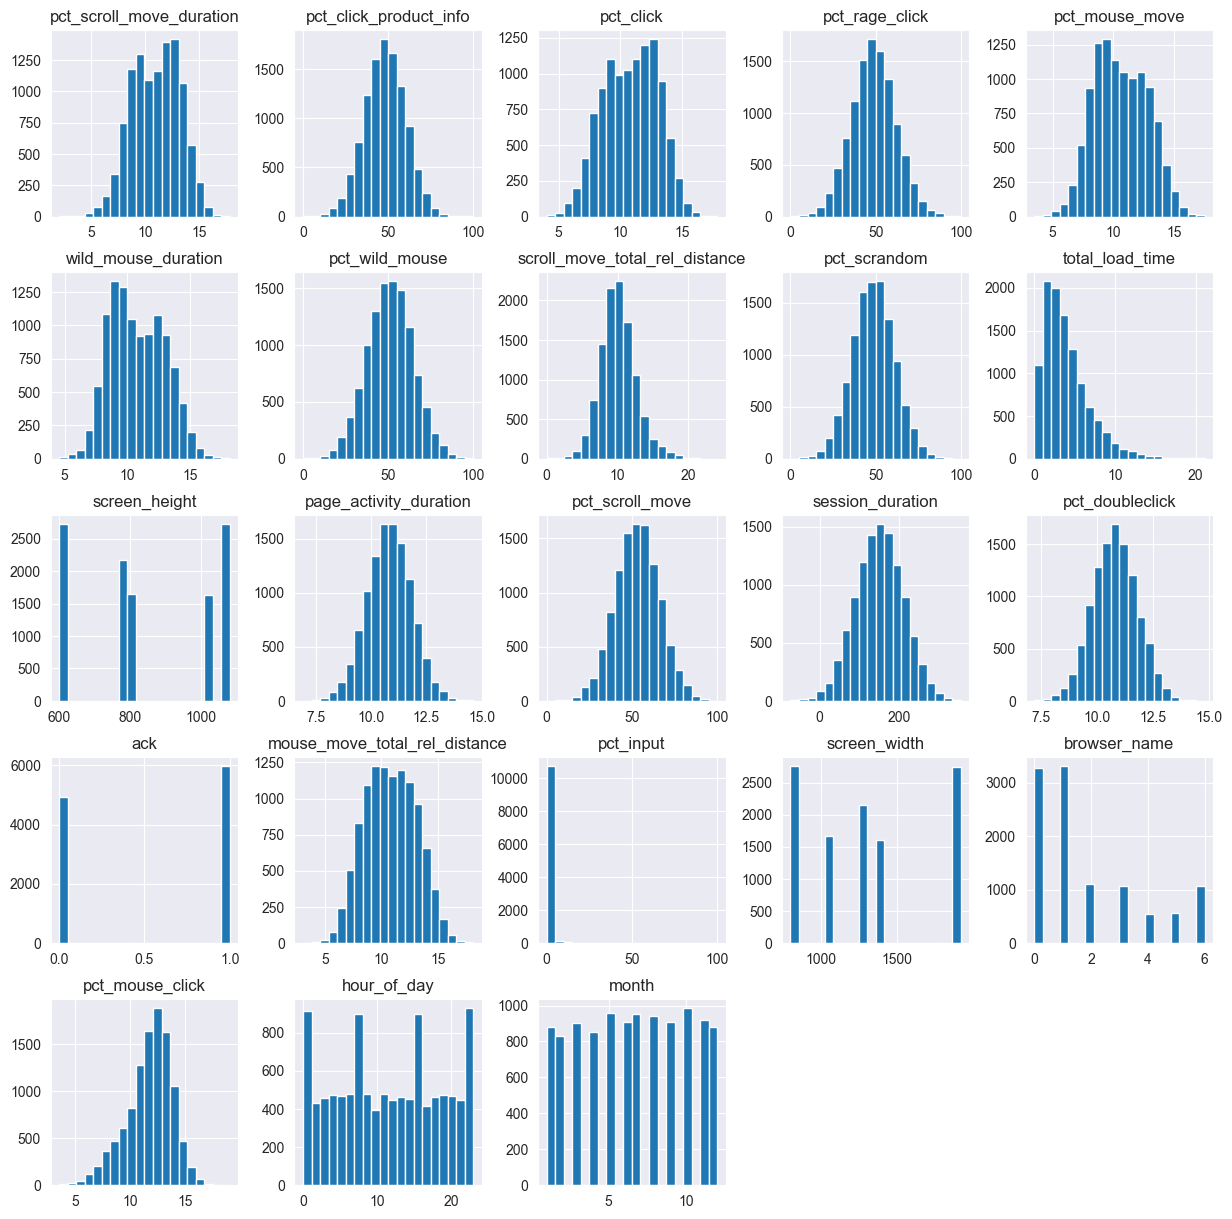

In [97]:
sessions.hist(bins=20, figsize=(15, 15))
plt.show()

### Rozdelenie vybraných stĺpcov na základe počtu vychýlených hodnôt

In [98]:
outlier_columns = ['pct_scroll_move_duration', 'pct_click_product_info', 'pct_click', 'pct_rage_click', 'pct_mouse_move', 'wild_mouse_duration', 'pct_wild_mouse', 'scroll_move_total_rel_distance', 'pct_scrandom', 'total_load_time', 'page_activity_duration', 'pct_scroll_move', 'session_duration', 'pct_doubleclick', 'mouse_move_total_rel_distance', 'pct_input', 'pct_mouse_click']

def find_outliers(data, outliers_count):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count[column] = len(data[(data < lower_bound) | (data > upper_bound)])

former_outlier_column_count = {}
for column in outlier_columns:
    find_outliers(sessions[column], former_outlier_column_count)

sorted_columns = sorted(former_outlier_column_count, key=former_outlier_column_count.get, reverse=True)
outliers1, outliers2 = sorted_columns[:len(null_cols)//2], null_cols[len(null_cols)//2:]
former_outlier_column_count

{'pct_scroll_move_duration': 6,
 'pct_click_product_info': 66,
 'pct_click': 1,
 'pct_rage_click': 88,
 'pct_mouse_move': 3,
 'wild_mouse_duration': 5,
 'pct_wild_mouse': 59,
 'scroll_move_total_rel_distance': 288,
 'pct_scrandom': 101,
 'total_load_time': 365,
 'page_activity_duration': 80,
 'pct_scroll_move': 66,
 'session_duration': 68,
 'pct_doubleclick': 79,
 'mouse_move_total_rel_distance': 8,
 'pct_input': 1490,
 'pct_mouse_click': 211}

### Nahradenie outliers pomocou hraničných hodnôt rozdelenia (5%, 95%)
Na prvú časť, ktorá obsahuje vysoký počet vychýlených hodnôt sme sa rozhodli aplikovať náhradu pomocou hraničných hodnôt, aby sme o údaje neprišli.

In [99]:
def replace_outliers_with_limits(dataframe, column_name):
    top_limit = dataframe[column_name].quantile(0.95)
    bottom_limit = dataframe[column_name].quantile(0.05)
    dataframe[column_name] = dataframe[column_name].clip(lower=top_limit, upper=bottom_limit)
    return dataframe

for column in outliers1:
    sessions = replace_outliers_with_limits(sessions, column)

### Odstránenie hraničných hodnôt na základe pozorovania
Vychýlené hodnoty druhej časti je možné jednoducho dropnúť 

In [100]:
def remove_outliers_iqr(dataframe, column_name, threshold=1.5):
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1

    outliers = (dataframe[column_name] < (Q1 - threshold * IQR)) | (dataframe[column_name] > (Q3 + threshold * IQR))
    cleaned_dataframe = dataframe.loc[~outliers]

    return cleaned_dataframe

for column in outliers2:
    sessions = remove_outliers_iqr(sessions, column)

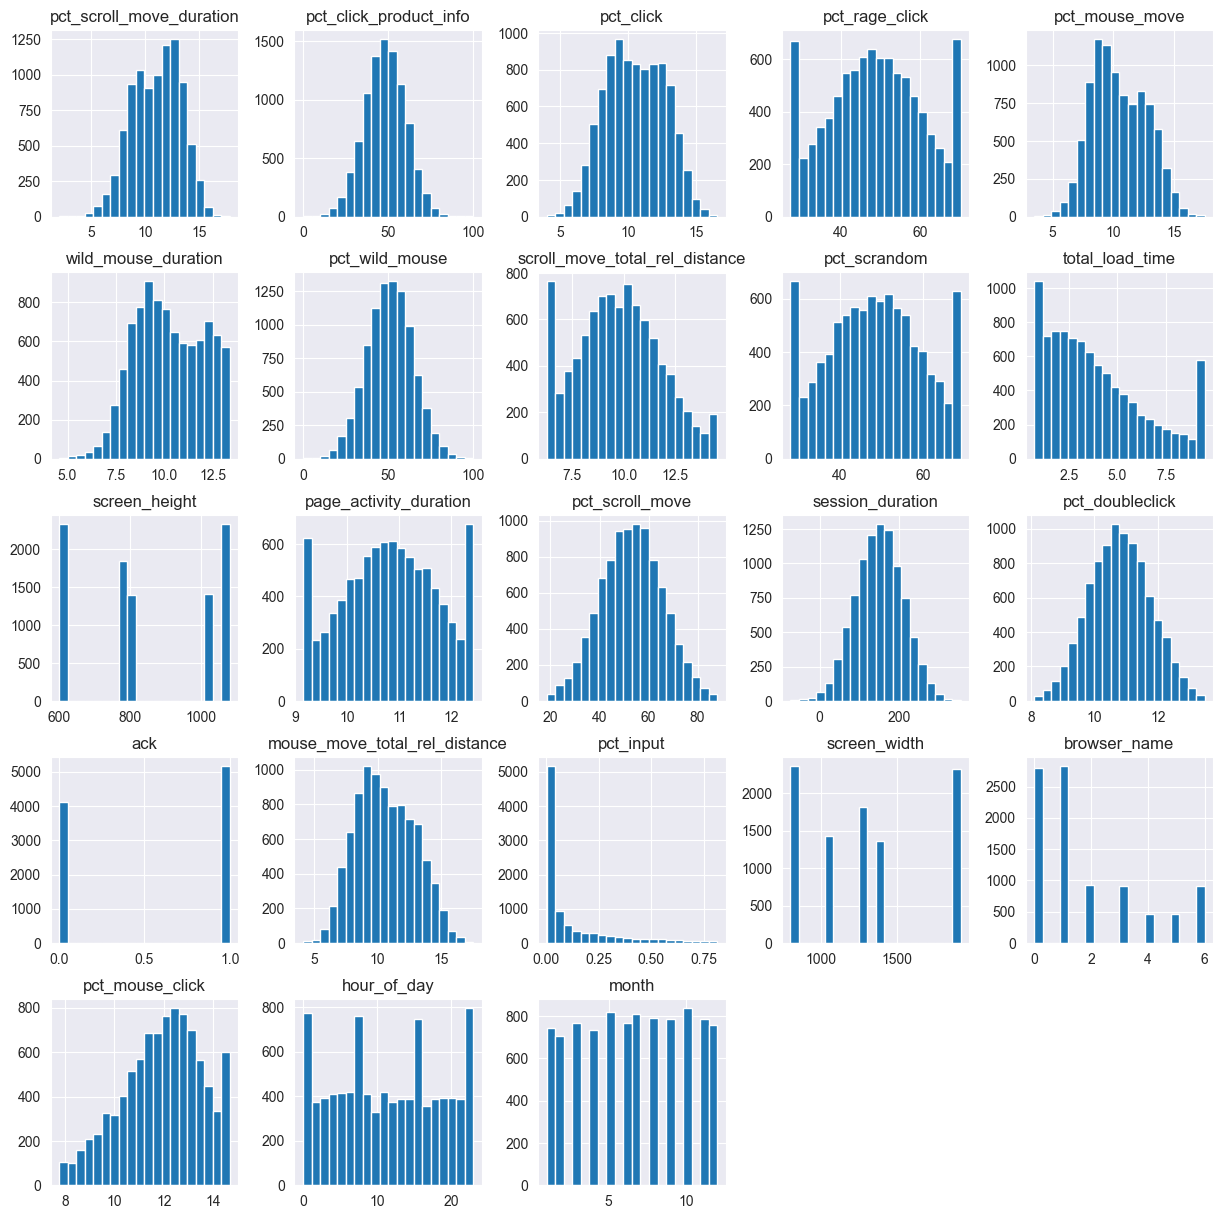

In [101]:
sessions.hist(bins=20, figsize=(15, 15))
plt.show()

### Počet vychýlených hodnôt sa nám podstatne znížil

In [102]:
def find_outliers(data, outliers_count):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count[column] = len(data[(data < lower_bound) | (data > upper_bound)])

outlier_column_count = {}
for column in outlier_columns:
    find_outliers(sessions[column], outlier_column_count)
outlier_column_count

{'pct_scroll_move_duration': 7,
 'pct_click_product_info': 58,
 'pct_click': 0,
 'pct_rage_click': 0,
 'pct_mouse_move': 0,
 'wild_mouse_duration': 1,
 'pct_wild_mouse': 48,
 'scroll_move_total_rel_distance': 0,
 'pct_scrandom': 0,
 'total_load_time': 0,
 'page_activity_duration': 0,
 'pct_scroll_move': 0,
 'session_duration': 54,
 'pct_doubleclick': 5,
 'mouse_move_total_rel_distance': 0,
 'pct_input': 999,
 'pct_mouse_click': 0}

### Kontrola pomocou heat mapy
### Pred odstranením vychýlených hodnôt

<Axes: >

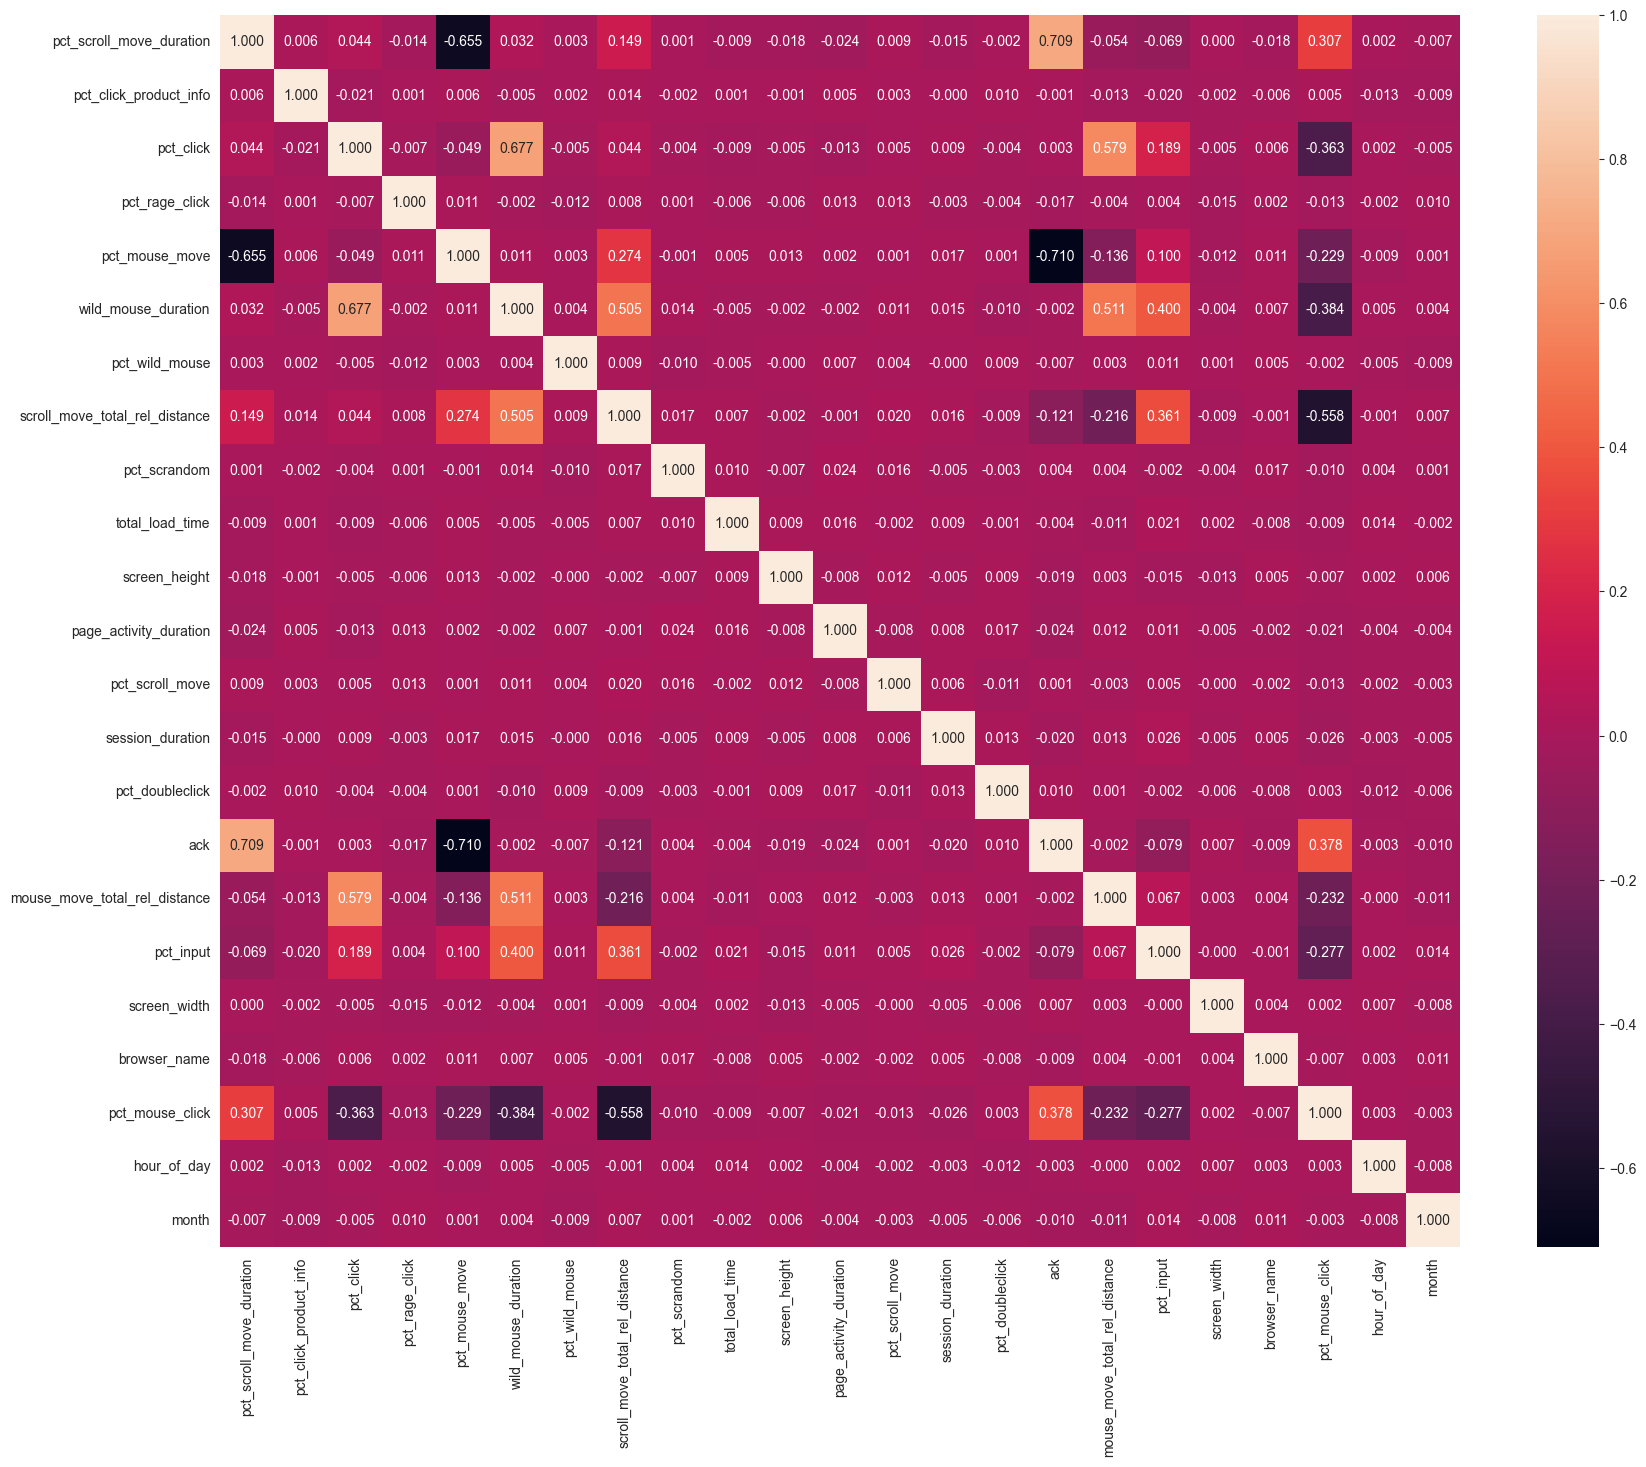

In [103]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(original_sessions.corr(),ax=ax, annot =True, fmt = ".3f")

### Po odstránení vychýlených hodnôt

<Axes: >

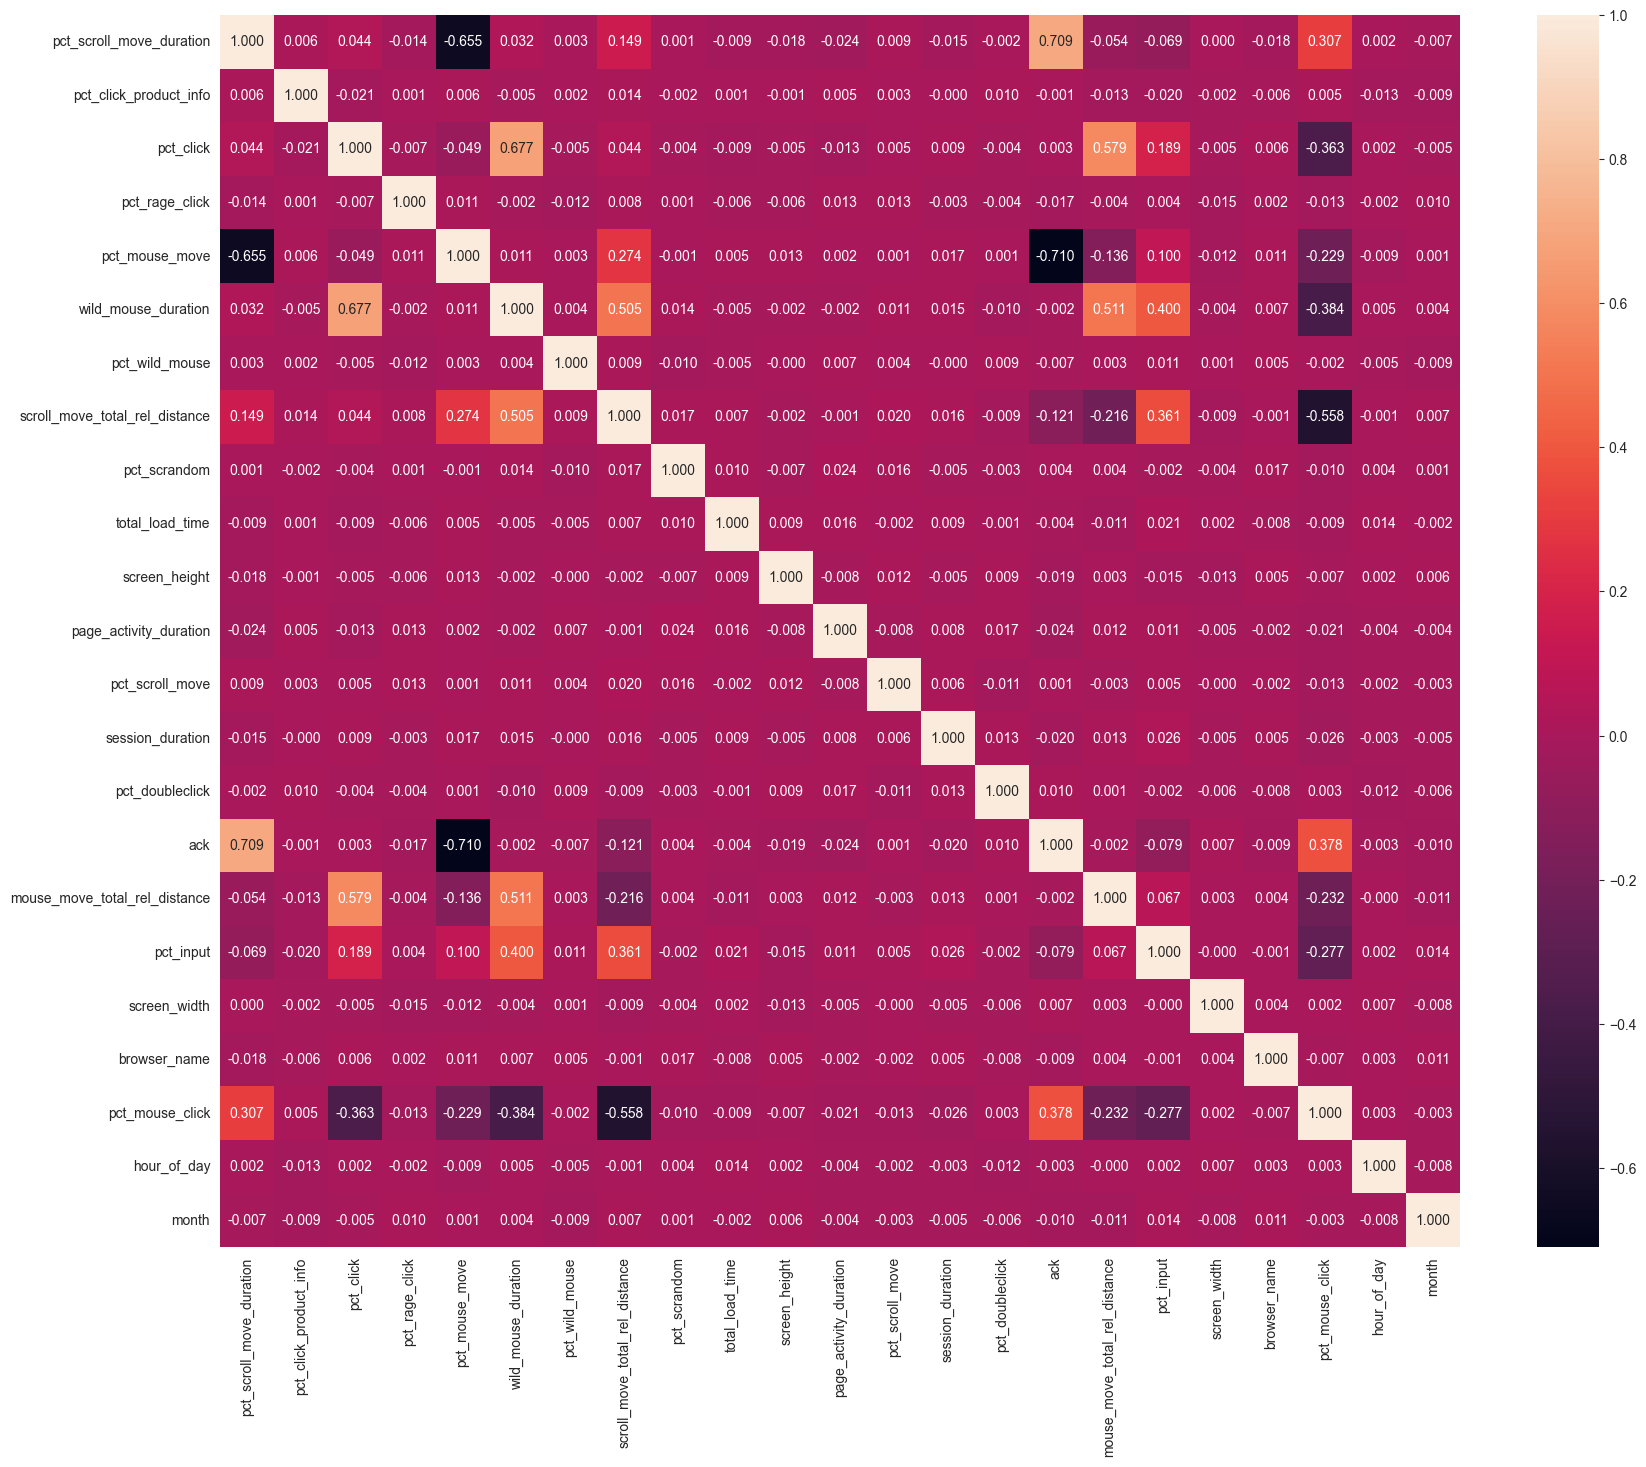

In [104]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(original_sessions.corr(),ax=ax, annot =True, fmt = ".3f")

## Realizácia predspracovania dát
### Rozdelenie na trénovaciu a testovaciu množinu
Keďže naše dáta už boli očistené a sú všetky v rovnakom formáte, `float64`, je možné si ich rozdeliť na trénovaciu a testovaciu množinu. Celkový počet dát je nízky, a preto sme sa zhodli, že rozdelenie 90:10 bude najoptimálnejšie, keďže chceme, aby náš model bol čo najefektívnejší. Taktiež si vytvoríme kópiu pôvodných trénovacích dát, aby sme vedeli porovnať ako sa naše dáta zmenili pred a po transformácií.

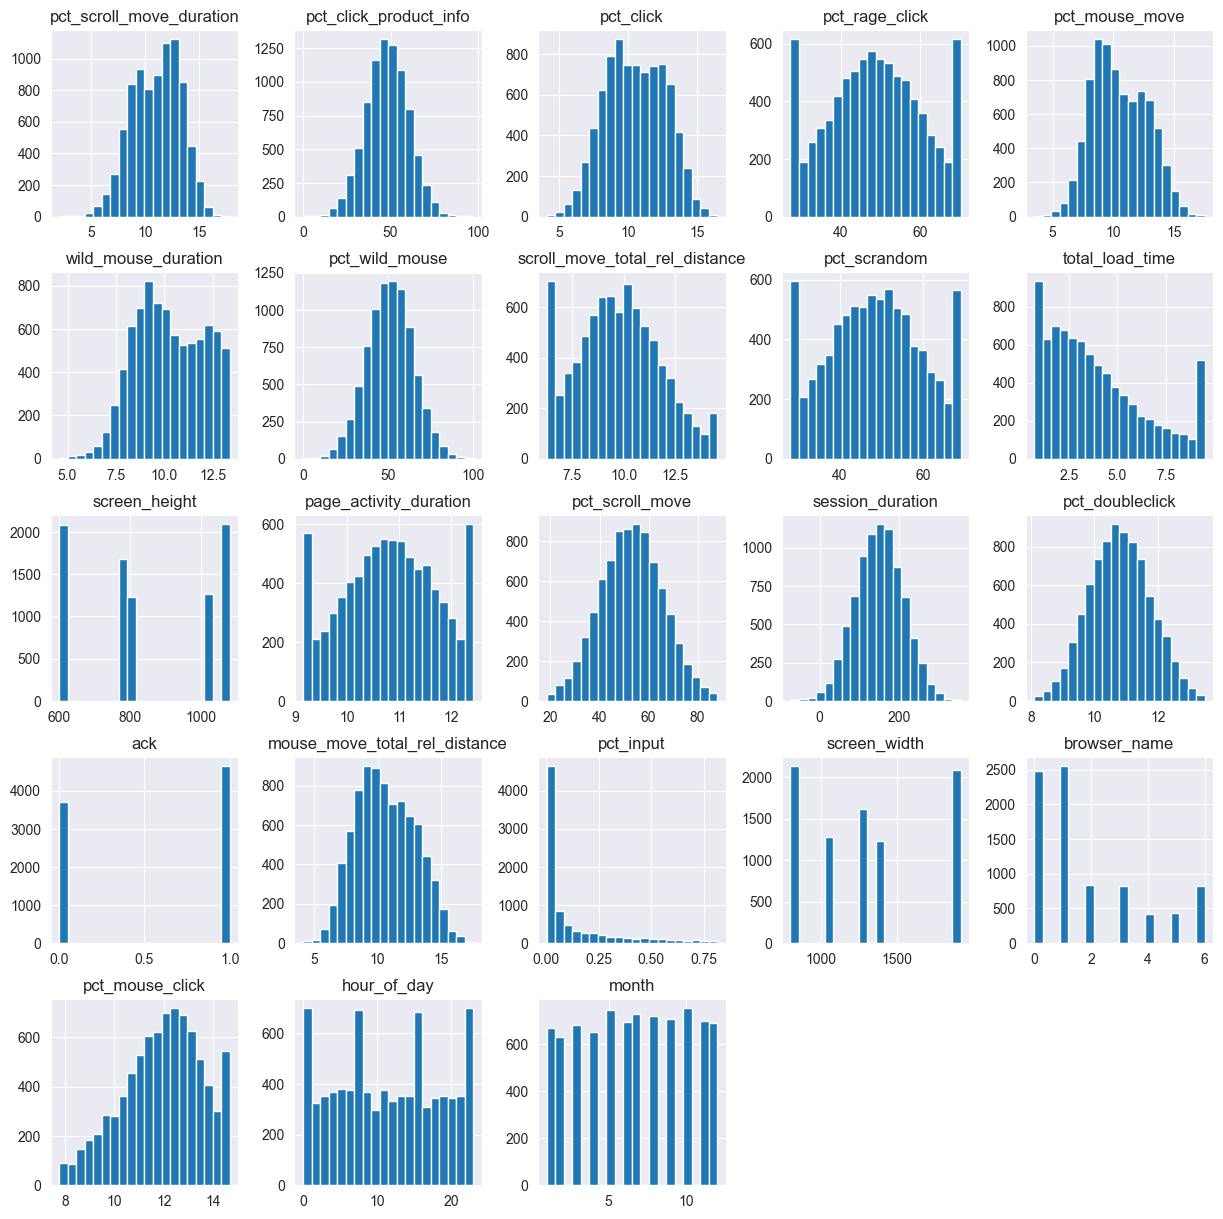

In [105]:
train_data, test_data= train_test_split(sessions, test_size=0.1, shuffle=True)
original_train_data = train_data.copy()
train_data.hist(bins=20, figsize=(15, 15))
plt.show()

### Transformácia atribútov dát
Na trénovacom datasete použijeme transformácie na to, aby sme našemu modelu zjednodušili prácu s datasetom:
* Power Transformer
* Data Normalization
* Robust Scaler 

Nazačiatku si zadefinujeme vizualizačnú funkciu, ktorá nám pomôže s porovnávaním pôvodnej formy trénovacieho datasetu s formou po transformácií.

In [106]:
def plot_qq_plots(data1, data2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("Before")
    stats.probplot(data1, plot=ax1, dist='norm', fit=True)
    ax2.set_title("After")
    stats.probplot(data2, plot=ax2, dist='norm', fit=True)
    plt.tight_layout()
    plt.show()

def plot_histograms(data1, data2, column_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.set_title("Before")
    ax1.hist(data1, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_xlabel(column_name)

    ax2.set_title("After")
    ax2.hist(data2, bins='auto', color='green', alpha=0.7, rwidth=0.85)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.set_xlabel(column_name)

    plt.tight_layout()
    plt.show()

### Power Transformer
Algoritmy strojového učenia dosahujú lepšie výsledky, keď sú atribúty distribuované podobne ako normálne, Gaussovské rozdelenie. PowerTransformer sa obvykle používa, keď sú dáta skewed a neobsahujú veľa vychýlených hodnôt, sklonené preto je potrebné ich identifikovať okometrickou metódou z histogramov. Po aplikovaní transformácie sa zmena vizualizuje.

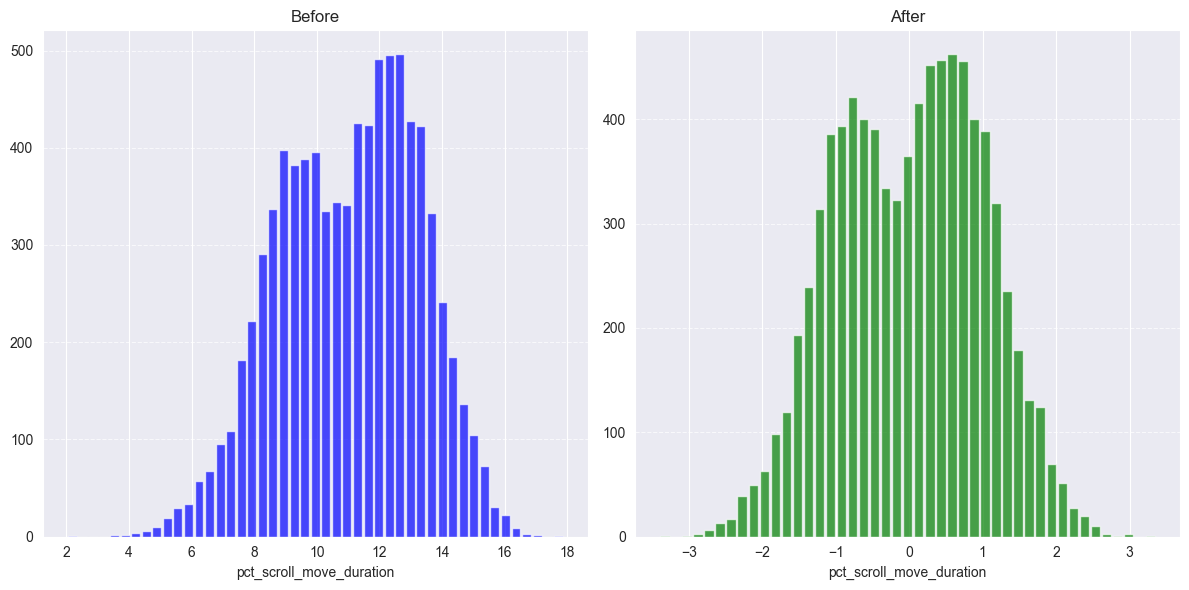

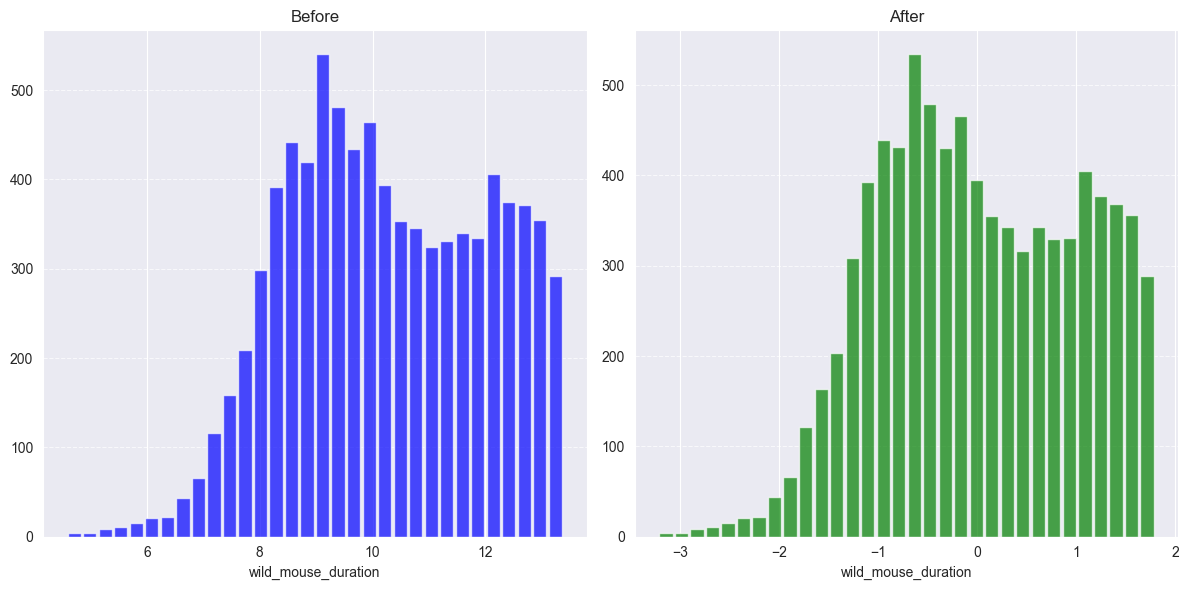

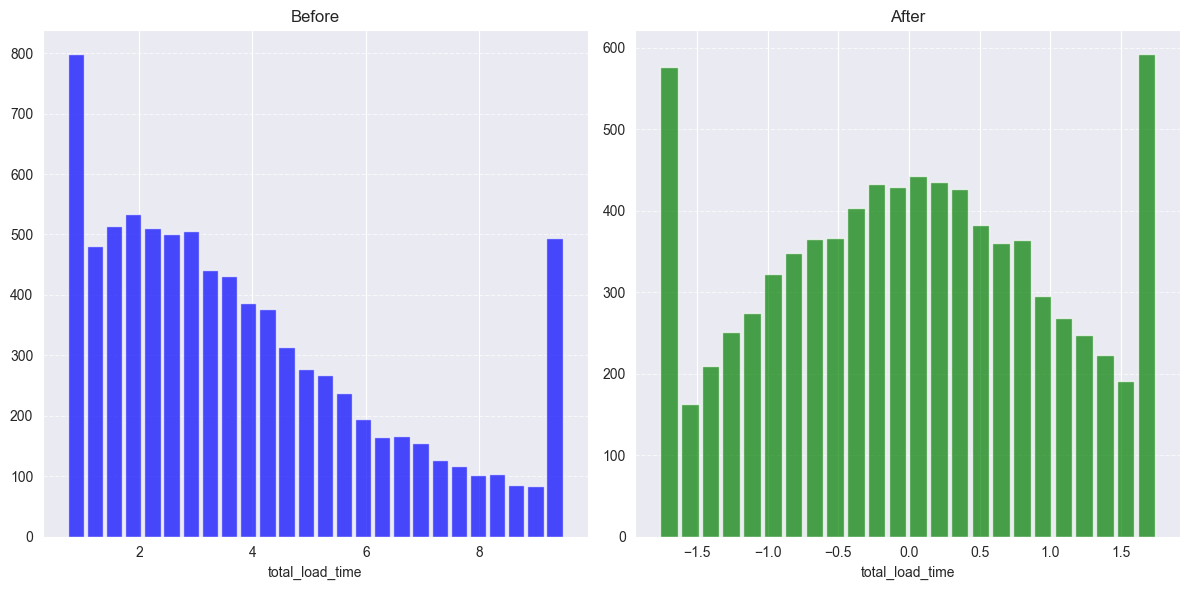

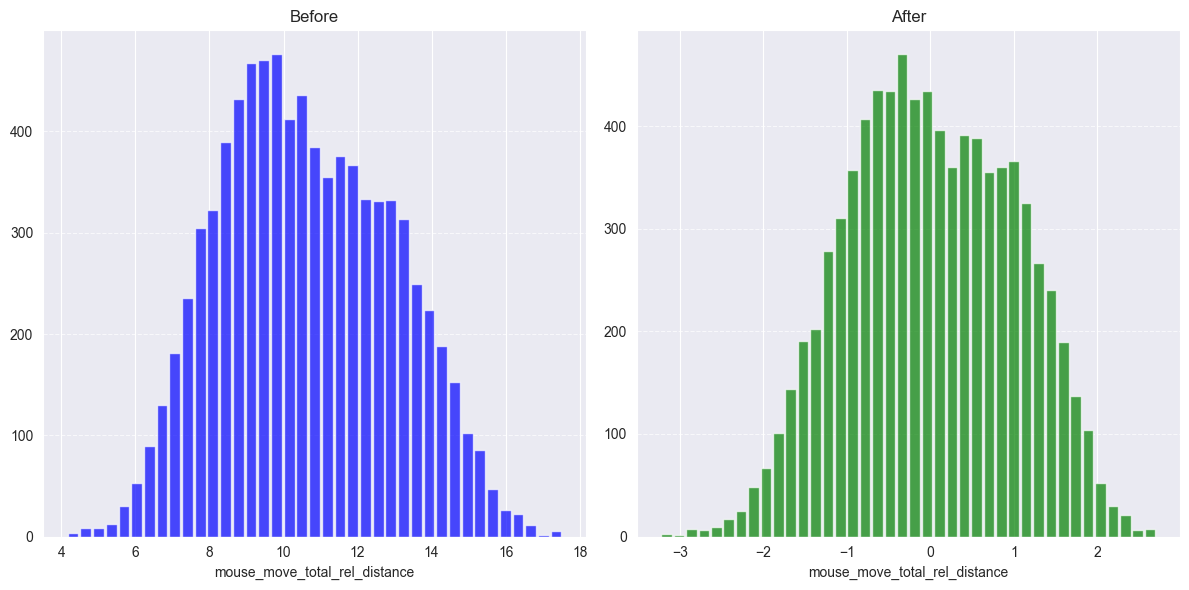

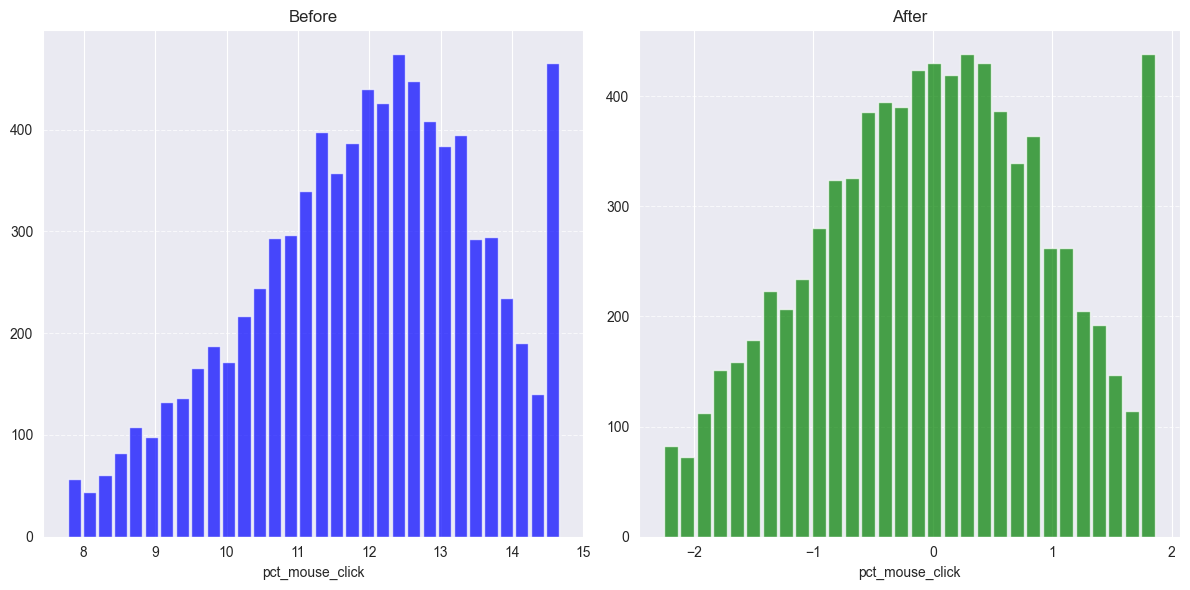

In [107]:
transformer = [
    "pct_scroll_move_duration",
    "wild_mouse_duration",
    "total_load_time",
    "mouse_move_total_rel_distance",
    "pct_mouse_click"
]

def power_transformer(dataframe, column):
    dataframe[column] = PowerTransformer().fit_transform(dataframe[[column]])
    return dataframe 

for column in transformer:
    train_data = power_transformer(train_data, column)
    plot_histograms(original_train_data[column], train_data[column], column)

### Data Normalization 
MinMax Scalerom dáta vieme normalizovať do menšieho rozsahu, obvykle medzi 0 a 1. Táto technika však nie je efektívna pokiaľ atribút obsahuje veľa vychýlených hodnôt preto je potrebné vybrať atribúty, ktoré nadobúdajú veľkú škálu hodnôt a obsahujú nízky počet vychýlených hodnôt.

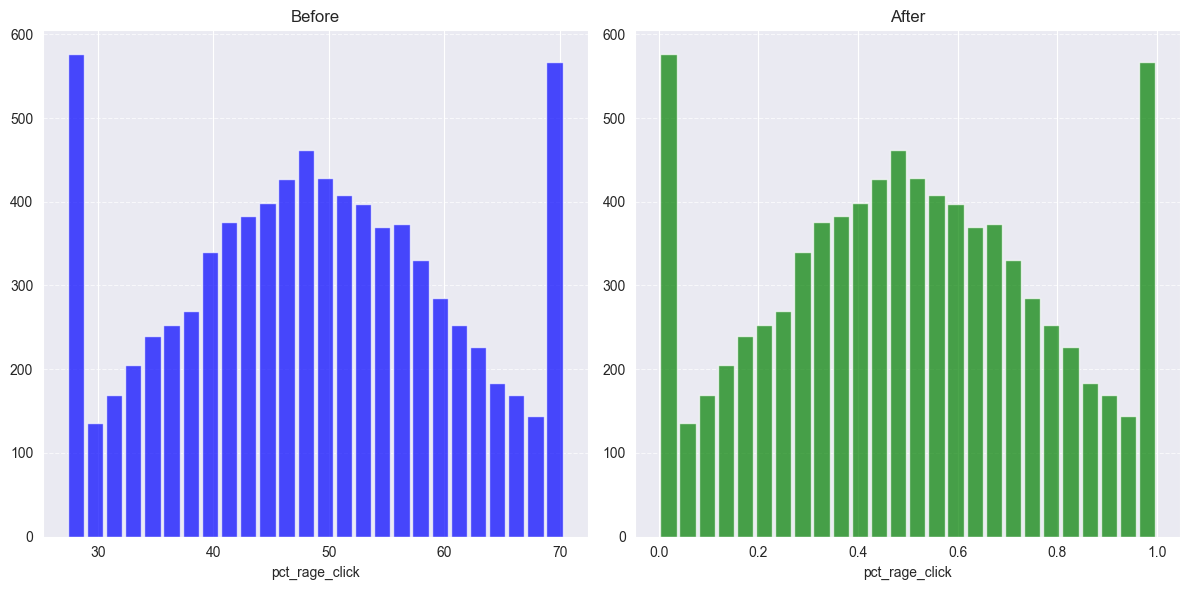

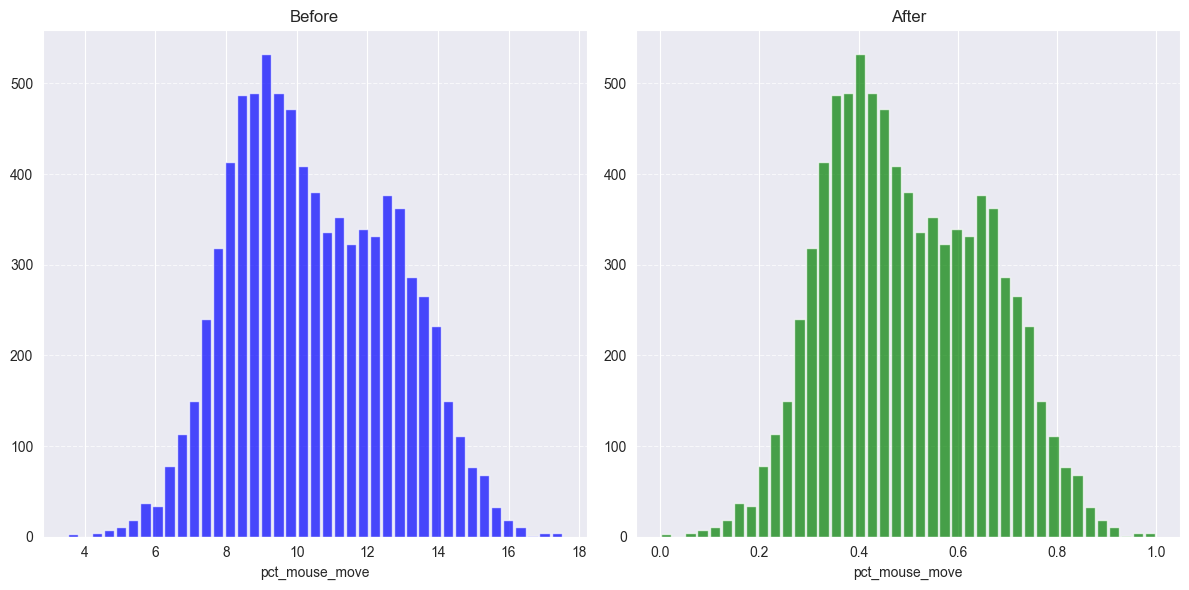

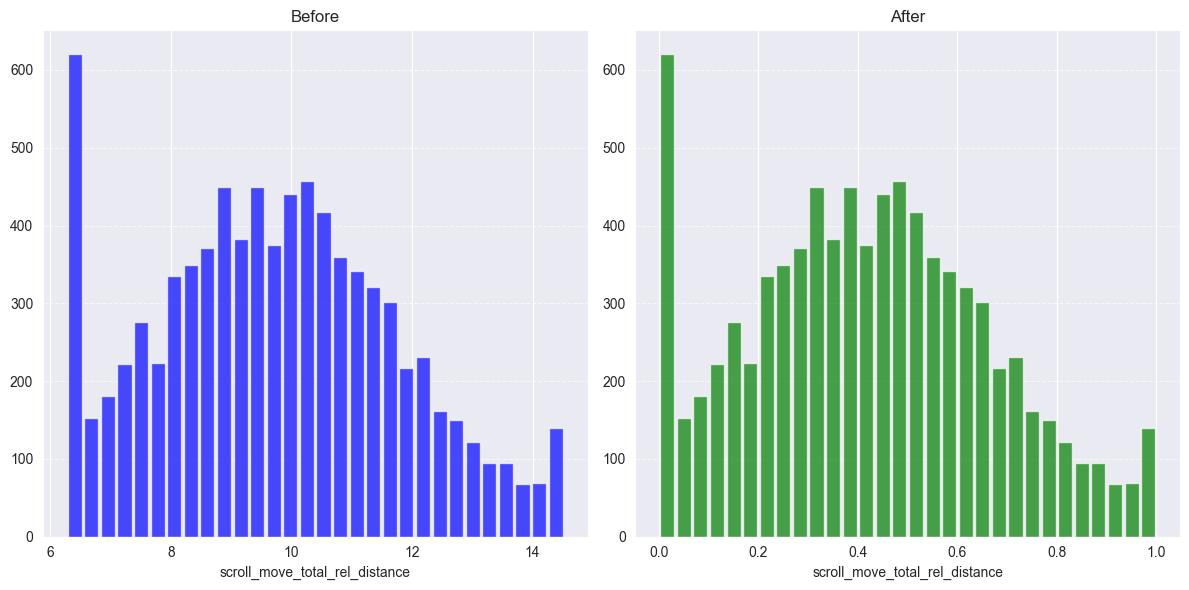

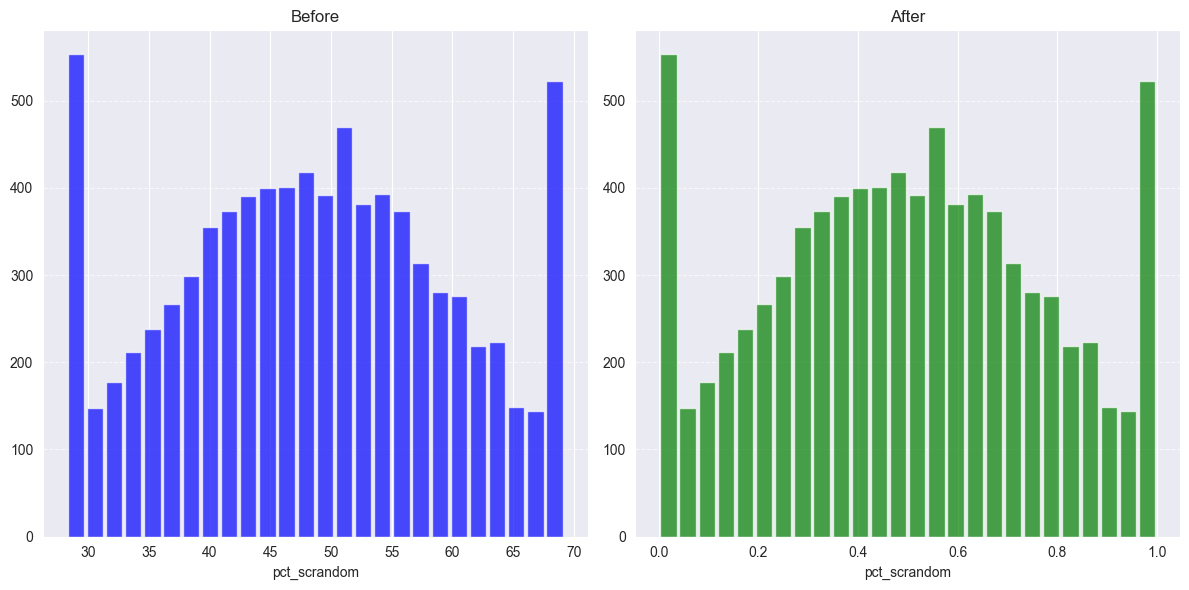

In [108]:
minmax = [
    "pct_rage_click",
    "pct_mouse_move",
    "scroll_move_total_rel_distance",
    "pct_scrandom"
]

def minmax_scaler(dataframe, column):
    dataframe[column] = MinMaxScaler().fit_transform(dataframe[[column]])
    return dataframe

for column in minmax:
    train_data = minmax_scaler(train_data, column)
    plot_histograms(original_train_data[column], train_data[column], column)

### Robust scaler
Cieľom tejto techniky je podobne ako pri Power Transformer priblížiť distribúciu atribútov k normálnemu rozdeleniu. Táto transformácia je užitočná predovšetkým pri práci s údajmi obsahujúcimi vychýlené hodnoty. RobustScaler sa s nimi vysporiada pomocou medzikvartilového rozsahu a mediánu. 

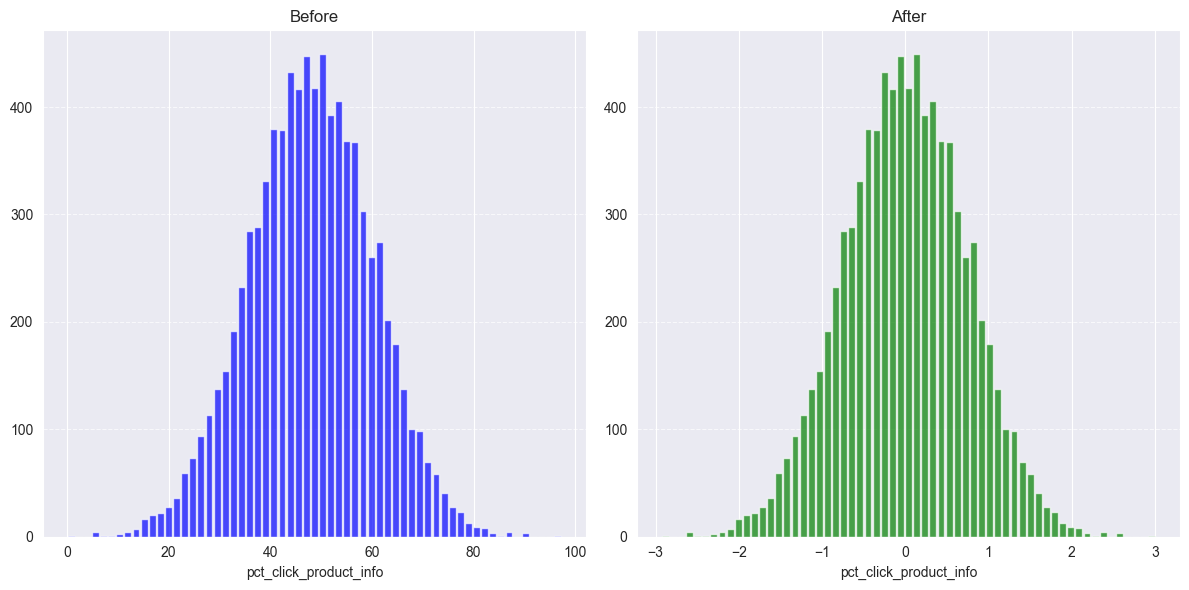

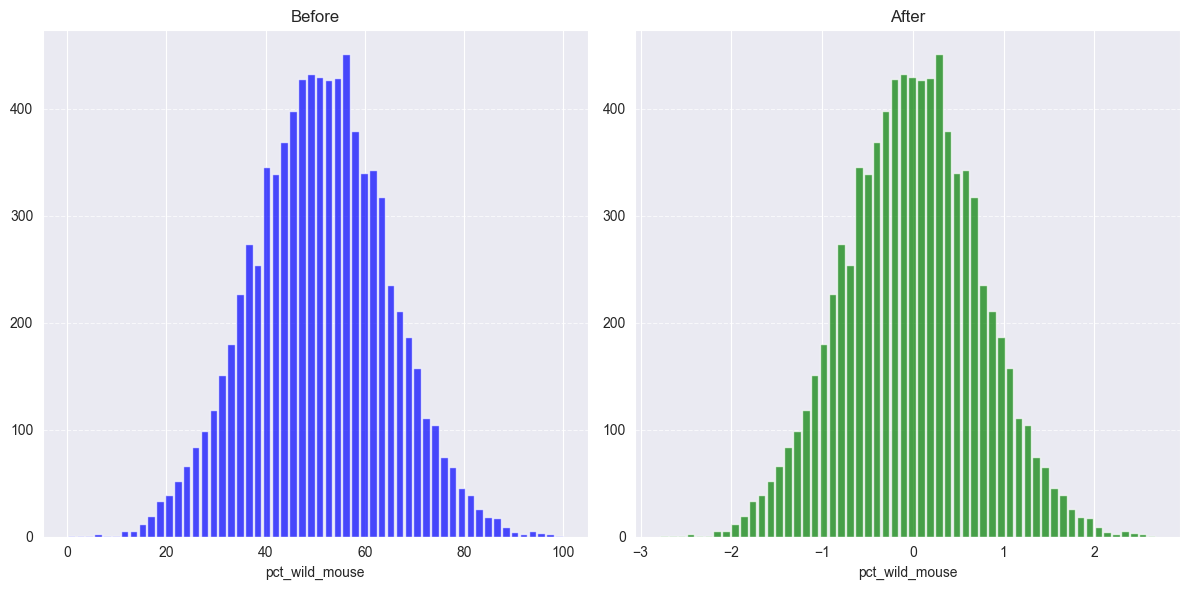

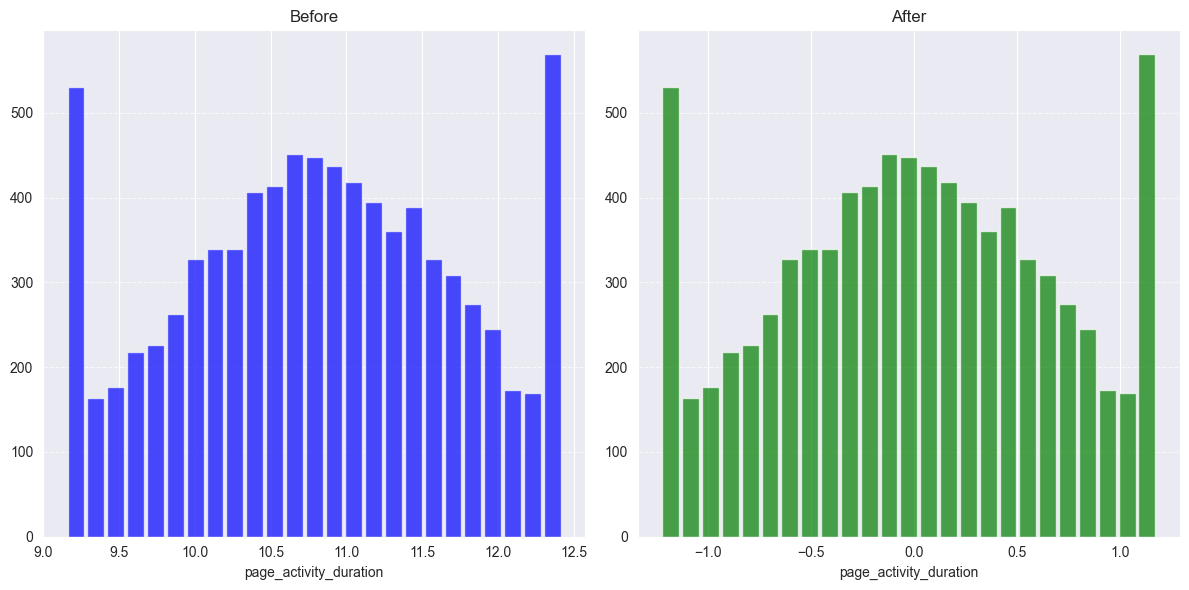

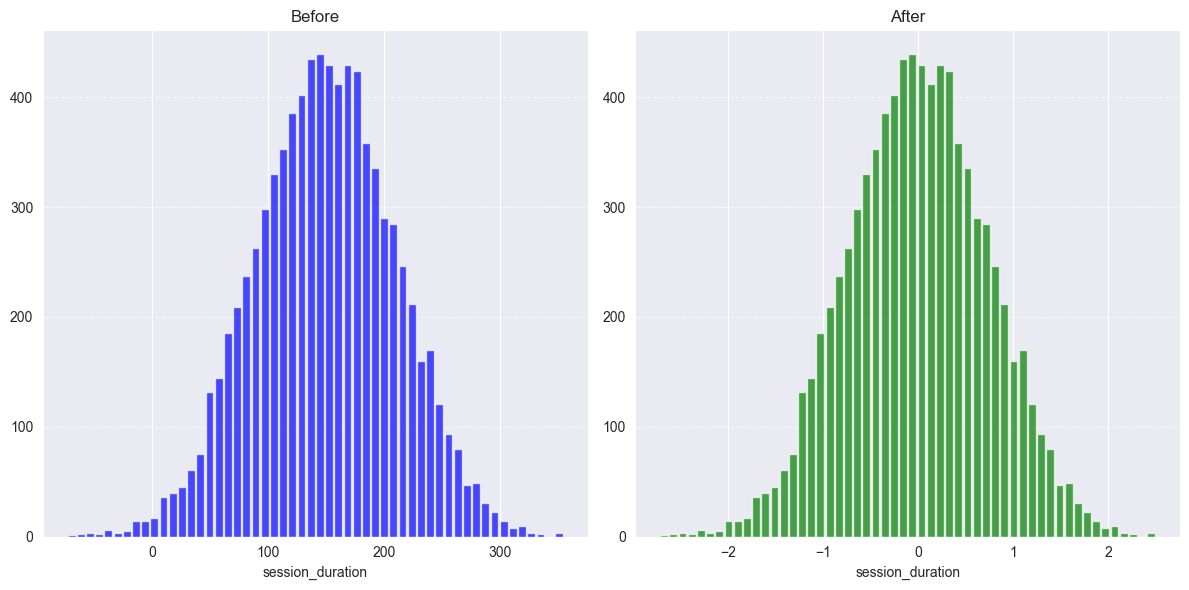

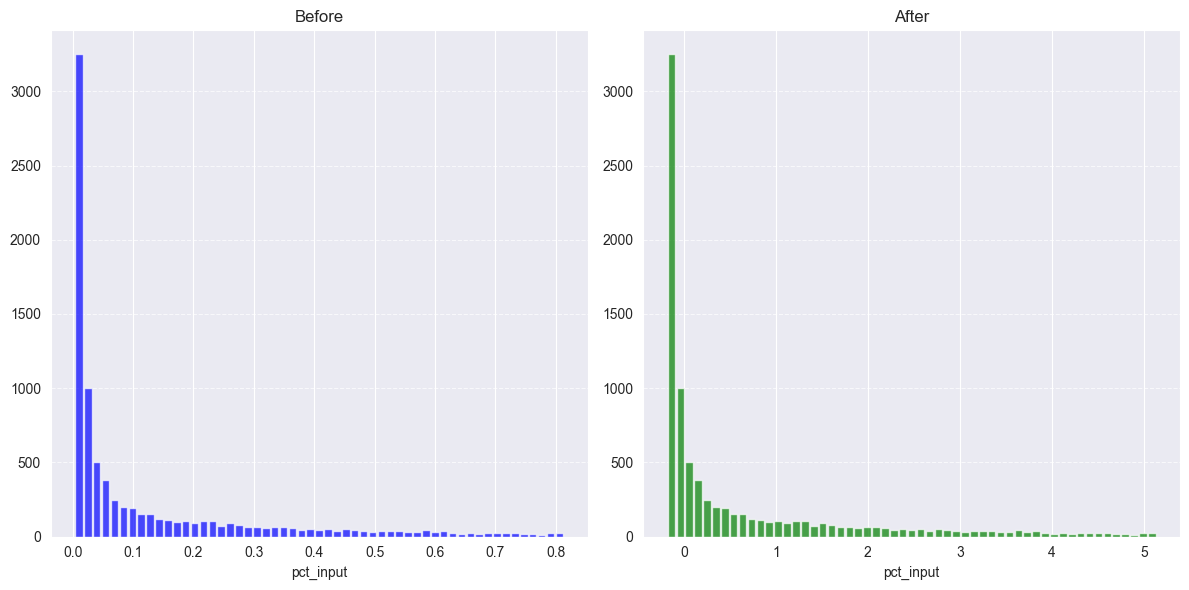

In [109]:
robust = [
    "pct_click_product_info",
    "pct_wild_mouse",
    "page_activity_duration",
    "session_duration",
    "pct_input"
]

def robust_scaler(dataframe, column):
    dataframe[column] = RobustScaler().fit_transform(dataframe[[column]])
    return dataframe

for column in robust:
    train_data = robust_scaler(train_data, column)
    plot_histograms(original_train_data[column], train_data[column], column)

## Výber atribútov pre strojové učenie
Na účely selekcie atribútov, ktoré najviac prispievajú k predikovanej premennej, sme sa rozhodli porovnať dva prístupy a následne zoradiť atribúty od najdôležitejších po najmenej dôležité:
* Select K Best
* Recursive Feature Elimination
    
### Select K Best
Bezkontextový výber, ktorý pozerá iba na koreláciu atribútu s `ack` a priradí im na základe toho skóre, následne je jednoduché atribúty zoradiť a vyberať `k=5` najdôležitejších atribútov.  

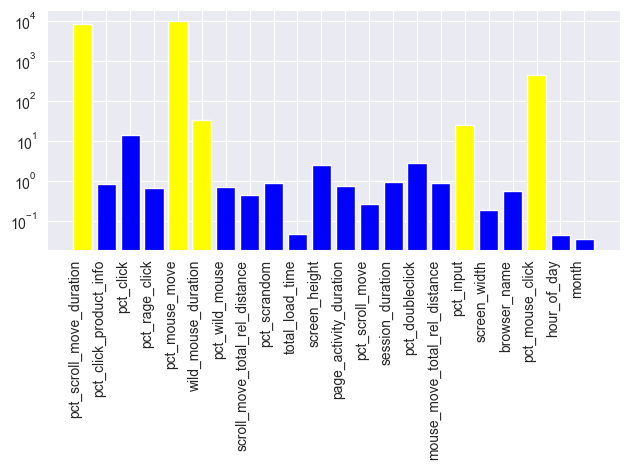

['pct_mouse_move', 'pct_scroll_move_duration', 'pct_mouse_click', 'wild_mouse_duration', 'pct_input']


In [110]:
X = train_data.drop('ack', axis=1)
y = train_data['ack']

k_best = SelectKBest(score_func=f_classif, k=5)
k_best.fit_transform(X, y)

def visualize_kbest(X, k_best, base_color='blue', chosen_color='yellow', top_k=5):
    top_k_indices = np.argsort(k_best.scores_)[-top_k:]

    colors = [chosen_color if i in top_k_indices else base_color for i in range(len(k_best.scores_))]

    plt.bar(range(len(X.columns)), k_best.scores_, color=colors)
    plt.xticks(range(len(X.columns)), X.columns, rotation='vertical', ha="right")
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    feature_scores_list = list(zip(X.columns, k_best.scores_))
    feature_scores_list.sort(key=lambda x: x[1], reverse=True)
    print([feature for feature, score in feature_scores_list[:5]])

visualize_kbest(X, k_best)

### Recursive Feature Elimination
Kontextový výber najdôležitejších atribútov, teda narozdiel od Select K Best sa táto metóda pozerá na atribúty v kontexte ostatných atribútov a na základe toho vyhodnocuje jeho vplyv na `ack`. Táto metóda postupne eliminuje menej dôležité atribúty z datasetu až dokým nenájde `k=5` najdôležitejších. Model, ktorý Recursive Feature Elimination pri výbere využíva môže byť rôzny my sme sa rozhodli pre `RandomForestClassifier`, pretože zabezpečuje presnosť.

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()  
rfe = RFE(model, n_features_to_select=5) 
rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print(list(selected_features))

['pct_scroll_move_duration', 'pct_mouse_move', 'wild_mouse_duration', 'mouse_move_total_rel_distance', 'pct_mouse_click']


## Overenie pomocou heat mapy
Metódy výberu atribútov pre strojové učenie dokážeme porovnať medzi sebou, no i za pomoci heat mapy. 

<Axes: >

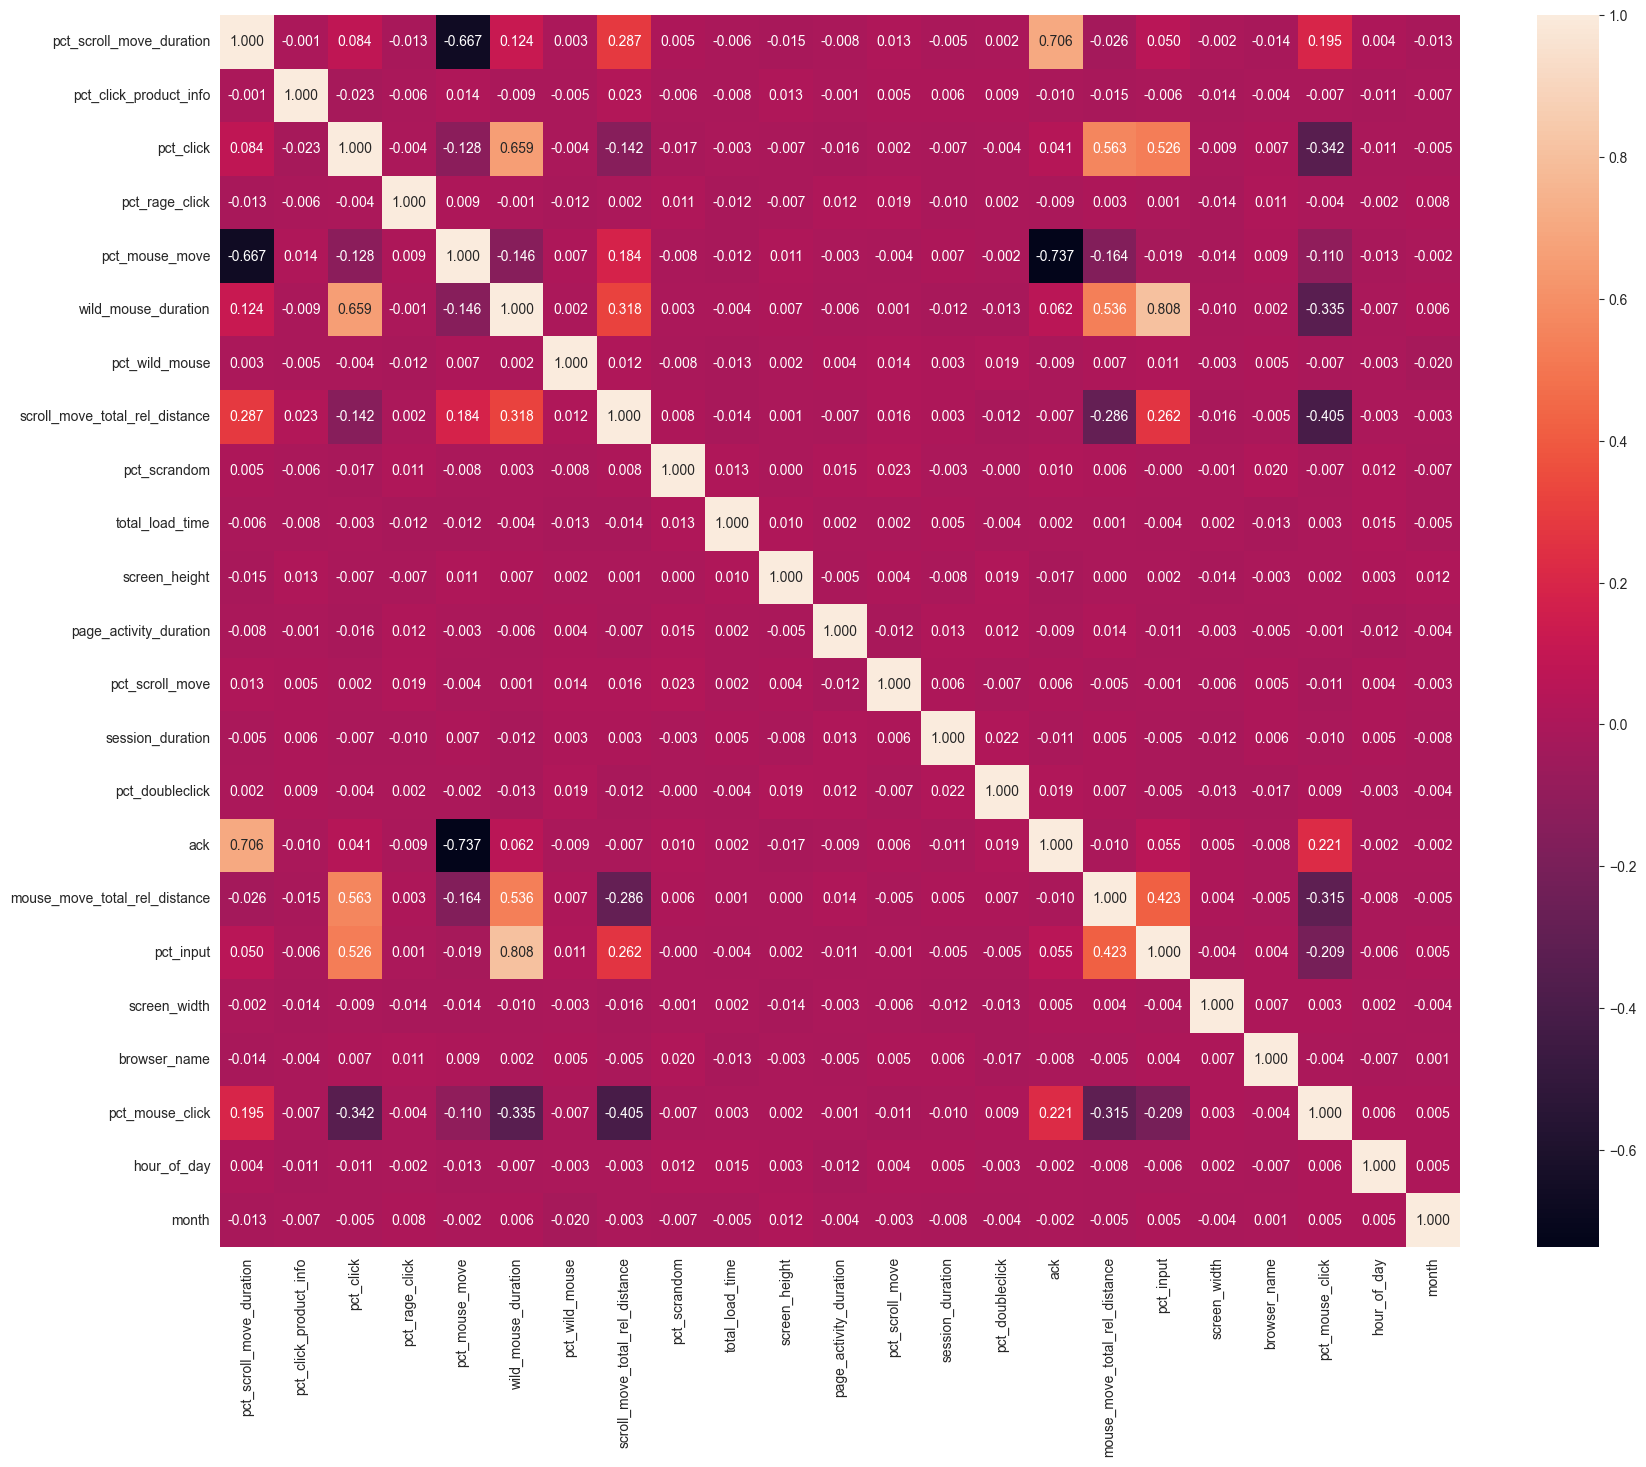

In [112]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(train_data.corr(),ax=ax, annot =True, fmt = ".3f")

# Replikovateľnosť predspracovania